## SALES ANALYSIS ##

**Import the required libraries**

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import glob
from scipy.stats import skew
from scipy import stats

In [32]:
path = r"C:\Users\subha\Downloads\Sales data"
csv_files = glob.glob(os.path.join(path, "*.csv"))
list = []
for file_name in csv_files:
    df = pd.read_csv(file_name, index_col= None , header = 0, error_bad_lines= False )
    list.append(df)
df = pd.concat(list, axis = 0, ignore_index= True)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [34]:
df.describe(include="all")

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


In [35]:
#formatting the names of the columns for the given dataframe
for i in df:
    df.columns = df.columns.astype(str)
    df.columns = df.columns.str.strip(" ")
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ","_")
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [36]:
#checking the number and presence of missing values in the main dataframe
df.isna().sum()

order_id            545
product             545
quantity_ordered    545
price_each          545
order_date          545
purchase_address    545
dtype: int64

In [37]:
#trying to understand the meaning of the meaning of missing values in the main dataframe
df_null = df.loc[df['order_id'].isnull()]
df_null.describe(include="all")

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
count,0,0,0,0,0,0
unique,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.order_date.describe()

count         186305
unique        142396
top       Order Date
freq             355
Name: order_date, dtype: object

In [61]:
#cleaning the dates in the dataframe 
df = df.loc[df['order_id'].notnull()]
df = df.loc[df['order_date'].notnull()]
df['order_date'] = pd.to_datetime(df['order_date'], errors = "coerce")

#setting up the datatypes of the columns
df['order_id'] = df['order_id'].astype(int)
df['quantity_ordered'] = df['quantity_ordered'].astype(int)
df['price_each'] = df['price_each'].astype(float)

#creating the month, year, month-year and purchase city columns from the data
df['month'] = pd.DatetimeIndex(df['order_date']).month
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['month_year'] = pd.to_datetime(df['order_date']).apply(lambda x: x.strftime("%B-%Y"))
df['purchase_city'] = df['purchase_address'].apply(lambda x: x.split(",")[1])

#creating the categories of the products
df['category'] = np.where(df['product'].str.contains('Headphones'),"Headphones",
                 np.where(df['product'].str.contains('Cable'),"Cable",
                 np.where(df['product'].str.contains('Batteries'),"Batteries",
                 np.where(df['product'].str.contains('Monitor'),"Monitor",
                 np.where(df['product'].str.contains('Phone'),"Phones",
                 np.where(df['product'].str.contains('TV|Television'),"Television",
                 np.where(df['product'].str.contains('Laptop'),"Laptop",
                 np.where(df['product'].str.contains('Washing|Dryer'),"Washing Machine and Dryers","Others"))))))))

#creating a calculated column for the total sales
df['total_sales'] = df['price_each']*df['quantity_ordered']
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,purchase_city,category,total_sales,month_year
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,Dallas,Cable,23.90,April-2019
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,Boston,Headphones,99.99,April-2019
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,Los Angeles,Phones,600.00,April-2019
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,Los Angeles,Headphones,11.99,April-2019
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,Los Angeles,Headphones,11.99,April-2019


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186849
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          185950 non-null  int32         
 1   product           185950 non-null  object        
 2   quantity_ordered  185950 non-null  int32         
 3   price_each        185950 non-null  float64       
 4   order_date        185950 non-null  datetime64[ns]
 5   purchase_address  185950 non-null  object        
 6   month             185950 non-null  int64         
 7   year              185950 non-null  int64         
 8   purchase_city     185950 non-null  object        
 9   category          185950 non-null  object        
 10  total_sales       185950 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2), object(4)
memory usage: 15.6+ MB


**Descriptive Statistics**

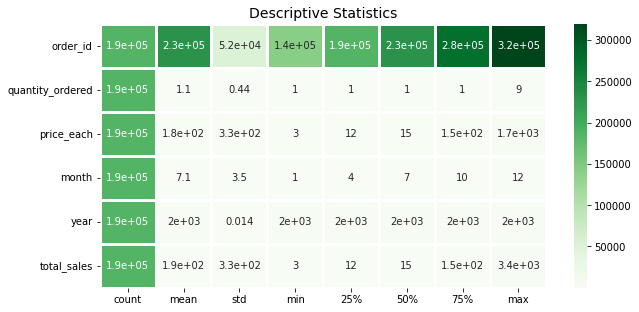

In [55]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index = dataframe.columns, columns = dataframe.describe().T.columns, data = dataframe.describe().T)
    f,ax = plt.subplots(figsize= (10, desc_df.shape[0]*0.81))
    sns.heatmap(desc_df, annot = True, cmap = "Greens", linecolor= "white", linewidths= 1.1)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
desc_stats(df.select_dtypes(include = ['float','int']))

**Exploratory Data Analysis**

<AxesSubplot: >

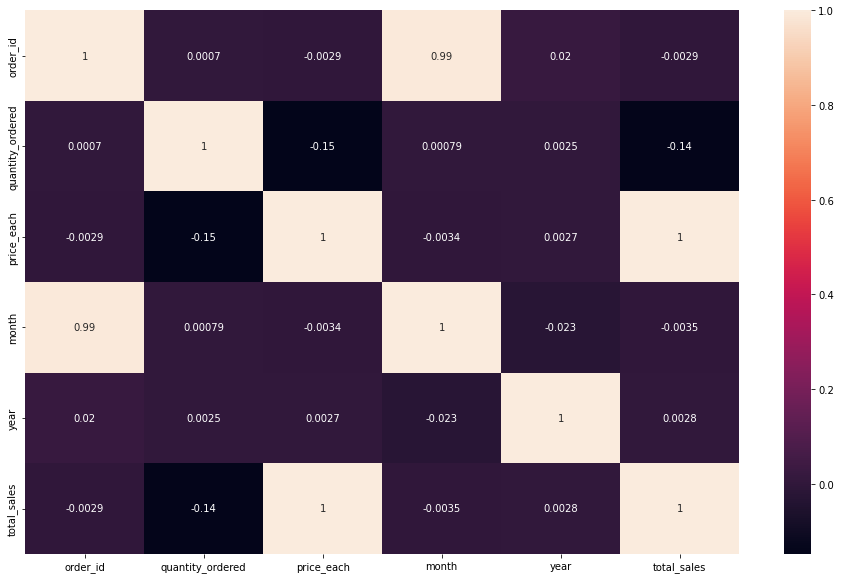

In [57]:
#correlation matrix and heatmap
figure = plt.figure(figsize= (16,10))
sns.heatmap(df.corr(), annot = True)

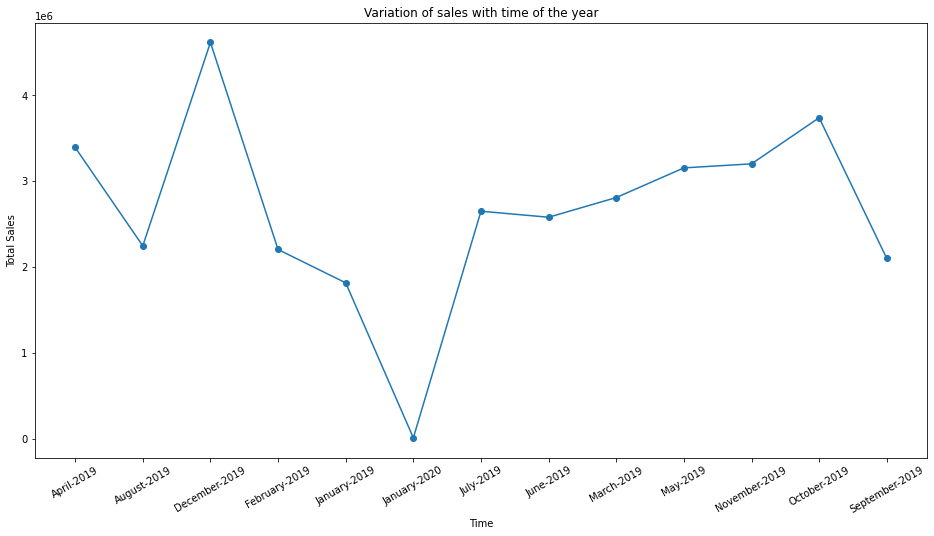

In [80]:
#change of sales with time
total_sales = df.groupby('month_year')['total_sales'].sum()
figure = plt.figure(figsize= (16,8))
plt.plot(total_sales, marker = "o")
plt.title("Variation of sales with time of the year")
plt.xticks(rotation = 30)
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.show()

<AxesSubplot: xlabel='count', ylabel='purchase_city'>

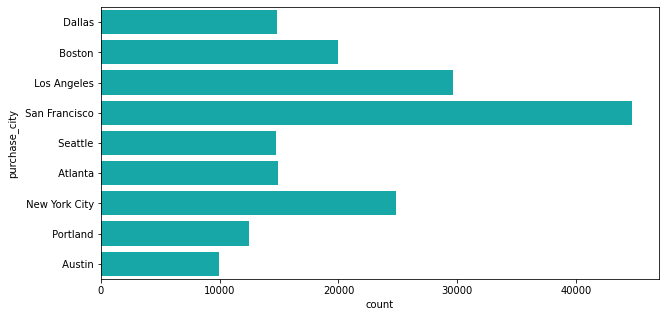

In [90]:
#understanding the cities in demand
plt.figure(figsize=(10,5))
sns.countplot(y = 'purchase_city', data = df, color ="c")

**Outlier Detection**

<AxesSubplot: xlabel='price_each', ylabel='Density'>

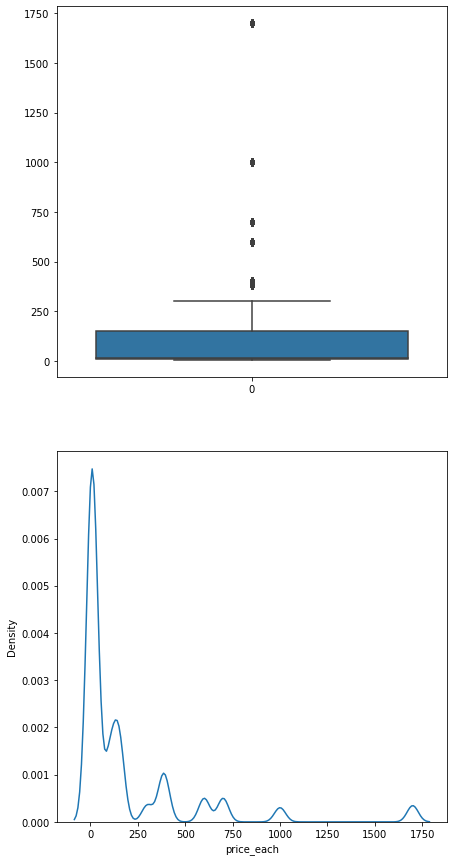

In [89]:
#boxplots for the detection of outliers in the data
plt.figure(figsize= (7,15))
plt.subplot(211)
sns.boxplot(df['price_each'])
plt.subplot(212)
sns.kdeplot(df['price_each'])

Lets quantify the amount of outliers present in the data

In [100]:
#IQR method
Q1 = np.percentile(df['price_each'], 25)
Q3 = np.percentile(df['price_each'], 75)
IQR = Q3-Q1 
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
outliers = df['price_each'][(df['price_each']> upper_bound)| (df['price_each'] < lower_bound)]

if len(outliers) == 0:
    print("There are no outliers in the data")
else:
    print("The number of outliers that are present in the data are : ", len(outliers))

The number of outliers that are present in the data are :  37007


In [121]:
#using z_scores for the detection of outliers
#but since the data in the price_each columns is not normally distributed, there it may be not very accurate in this particular data
skewness = df['price_each'].skew()
z_scores = np.abs(stats.zscore(df['price_each']))
outliers = (z_scores > 3).any(axis = 1)
len(outliers)   
